## Imports

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

## Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/NewsStocksData
!ls

Mounted at /content/drive/
/content/drive/MyDrive/NewsStocksData
catboost_info  data.csv  new.xlsx  yahoo_data.xlsx


## Load data & transformations

The dataset includes the following columns:

**Date**: The date on which the stock market data was recorded.

**Open**: The opening price of the asset on the given date.

**High**: The highest price of the asset on the given date.

**Low**: The lowest price of the asset on the given date.

**Close**: The closing price of the asset on the given date. Note that this price does not take into account any after-hours trading that may have occurred after the market officially closed.

**Adj Close**: The adjusted closing price of the asset on the given date. This price takes into account any dividends, stock splits, or other corporate actions that may have occurred, which can affect the stock price.

**Volume**: The total number of shares of the asset that were traded on the given date.

In [ ]:
df = pd.read_excel('yahoo_data.xlsx')

In [ ]:
df.to_csv('data.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [ ]:
# delete close as we have adjusted close which is more accurate
df = df.drop('Close*', axis=1)

In [ ]:
# string to datetime and sort ascending
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.to_csv('data.csv') # save

In [ ]:
df.head()

,Date,Open,High,Low,Adj Close**,Volume
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,380070000
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,385350000
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,389240000
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,329480000
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,307670000


## EDA

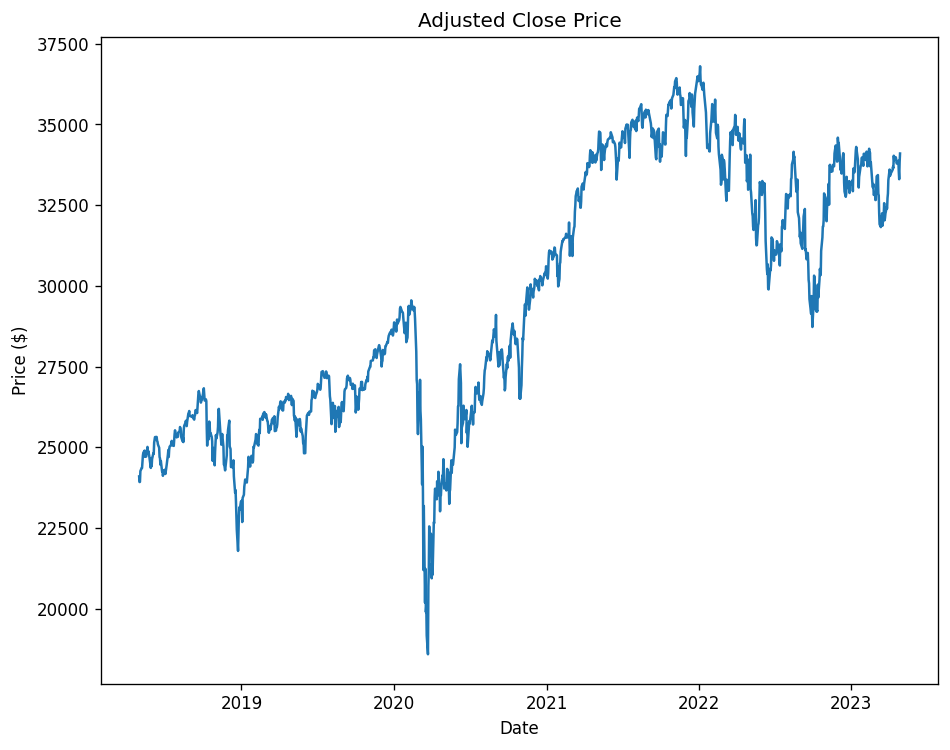

In [ ]:
plt.plot(df['Date'], df['Adj Close**'])
plt.title('Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

<ipython-input-78-24bed48b1dd1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


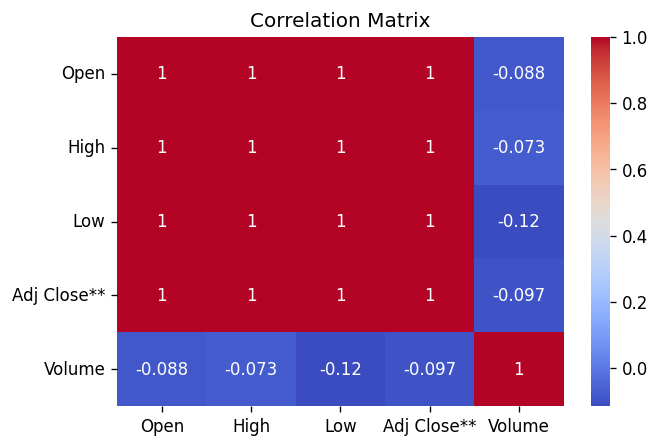

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show();

**Volume has very low correlation with other features!**

Checking NAN values:

In [ ]:
df.isna().sum()

Date           0
Open           0
High           0
Low            0
Adj Close**    0
Volume         0
dtype: int64

Volume traded

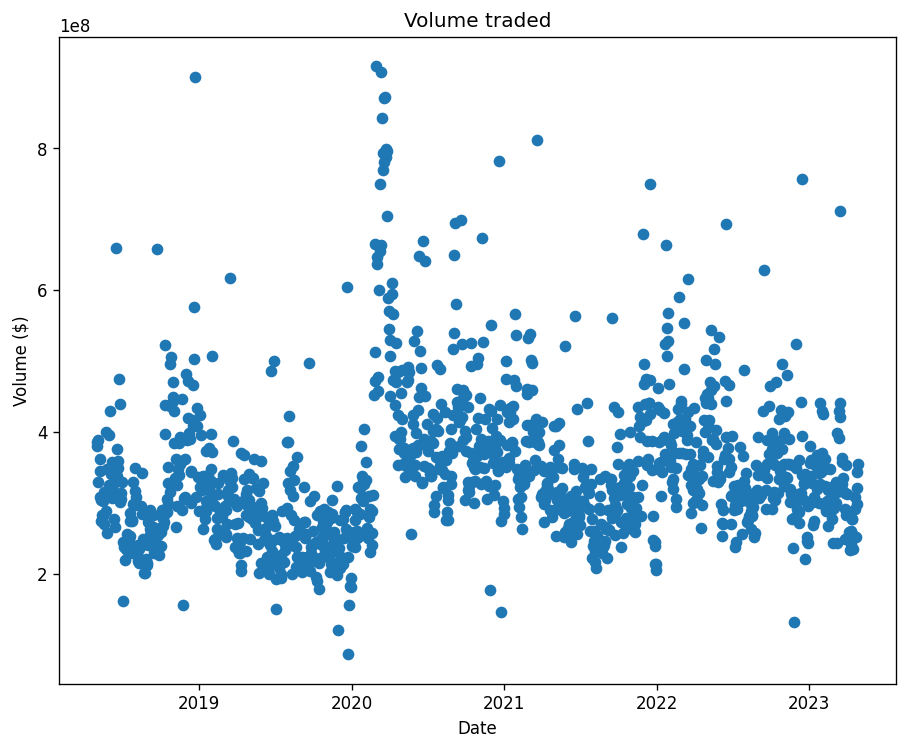

In [ ]:
plt.scatter(df['Date'], df['Volume'])
plt.title('Volume traded')
plt.xlabel('Date')
plt.ylabel('Volume ($)')
plt.show()

Resampling Adj Close column month wise

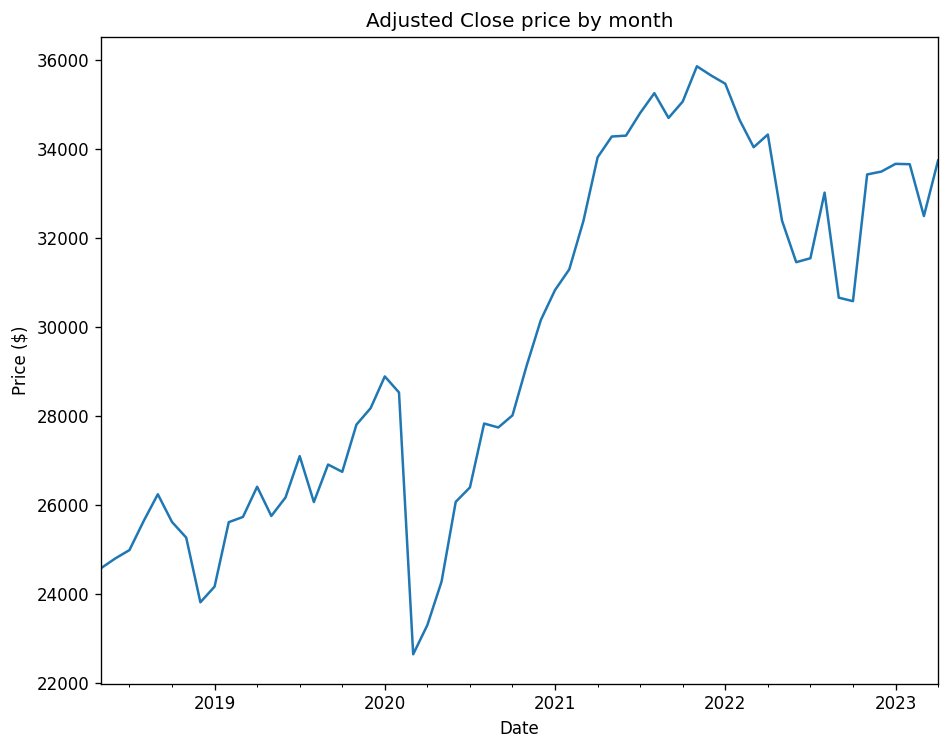

In [ ]:
df2 = df.set_index('Date')
df2['Adj Close**'].resample('M').mean().plot()
plt.title('Adjusted Close price by month')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

Resampling Adj Close column year wise

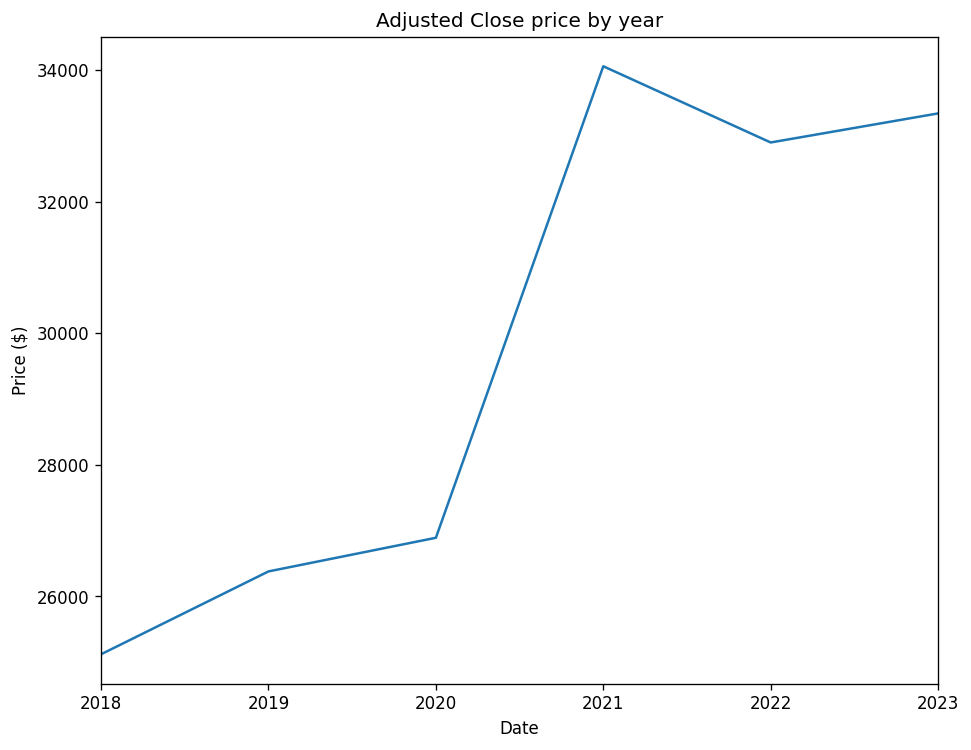

In [ ]:
df2['Adj Close**'].resample('Y').mean().plot()
plt.title('Adjusted Close price by year')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

## Dickey-Fuller Test for stationary

In [ ]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Closing Price")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

def check_adfuller(df):
  result=adfuller(df)
  print('Test Statistic: %f' %result[0])
  print('p-value: %f' %result[1])
  print('Critical values:')
  for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))


# ARIMA

## Finding parameters for ARIMA algorithms

These parameters can be explained as follows

1.   p is the number of autoregressive terms,
2.   d is the number of nonseasonal differences,
3.   q is the number of lagged forecast errors in the prediction equation.



In [ ]:
data = df[['Adj Close**']]
data = data.set_index(df['Date'])
data.head(3)

,Adj Close**
Date,
2018-05-01,24099.05
2018-05-02,23924.98
2018-05-03,23930.15


<Axes: xlabel='Date'>

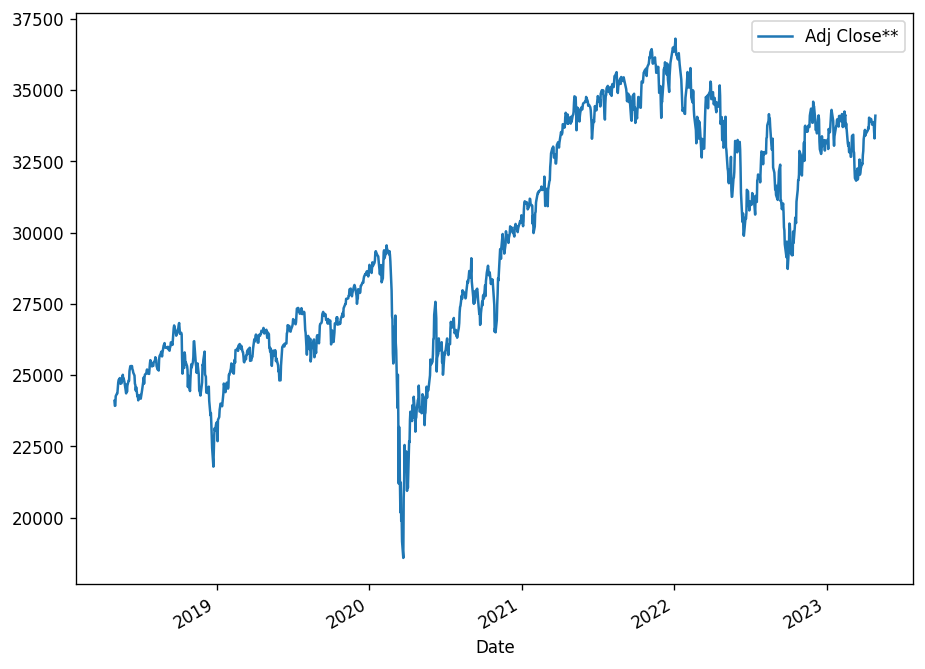

In [ ]:
data.plot()

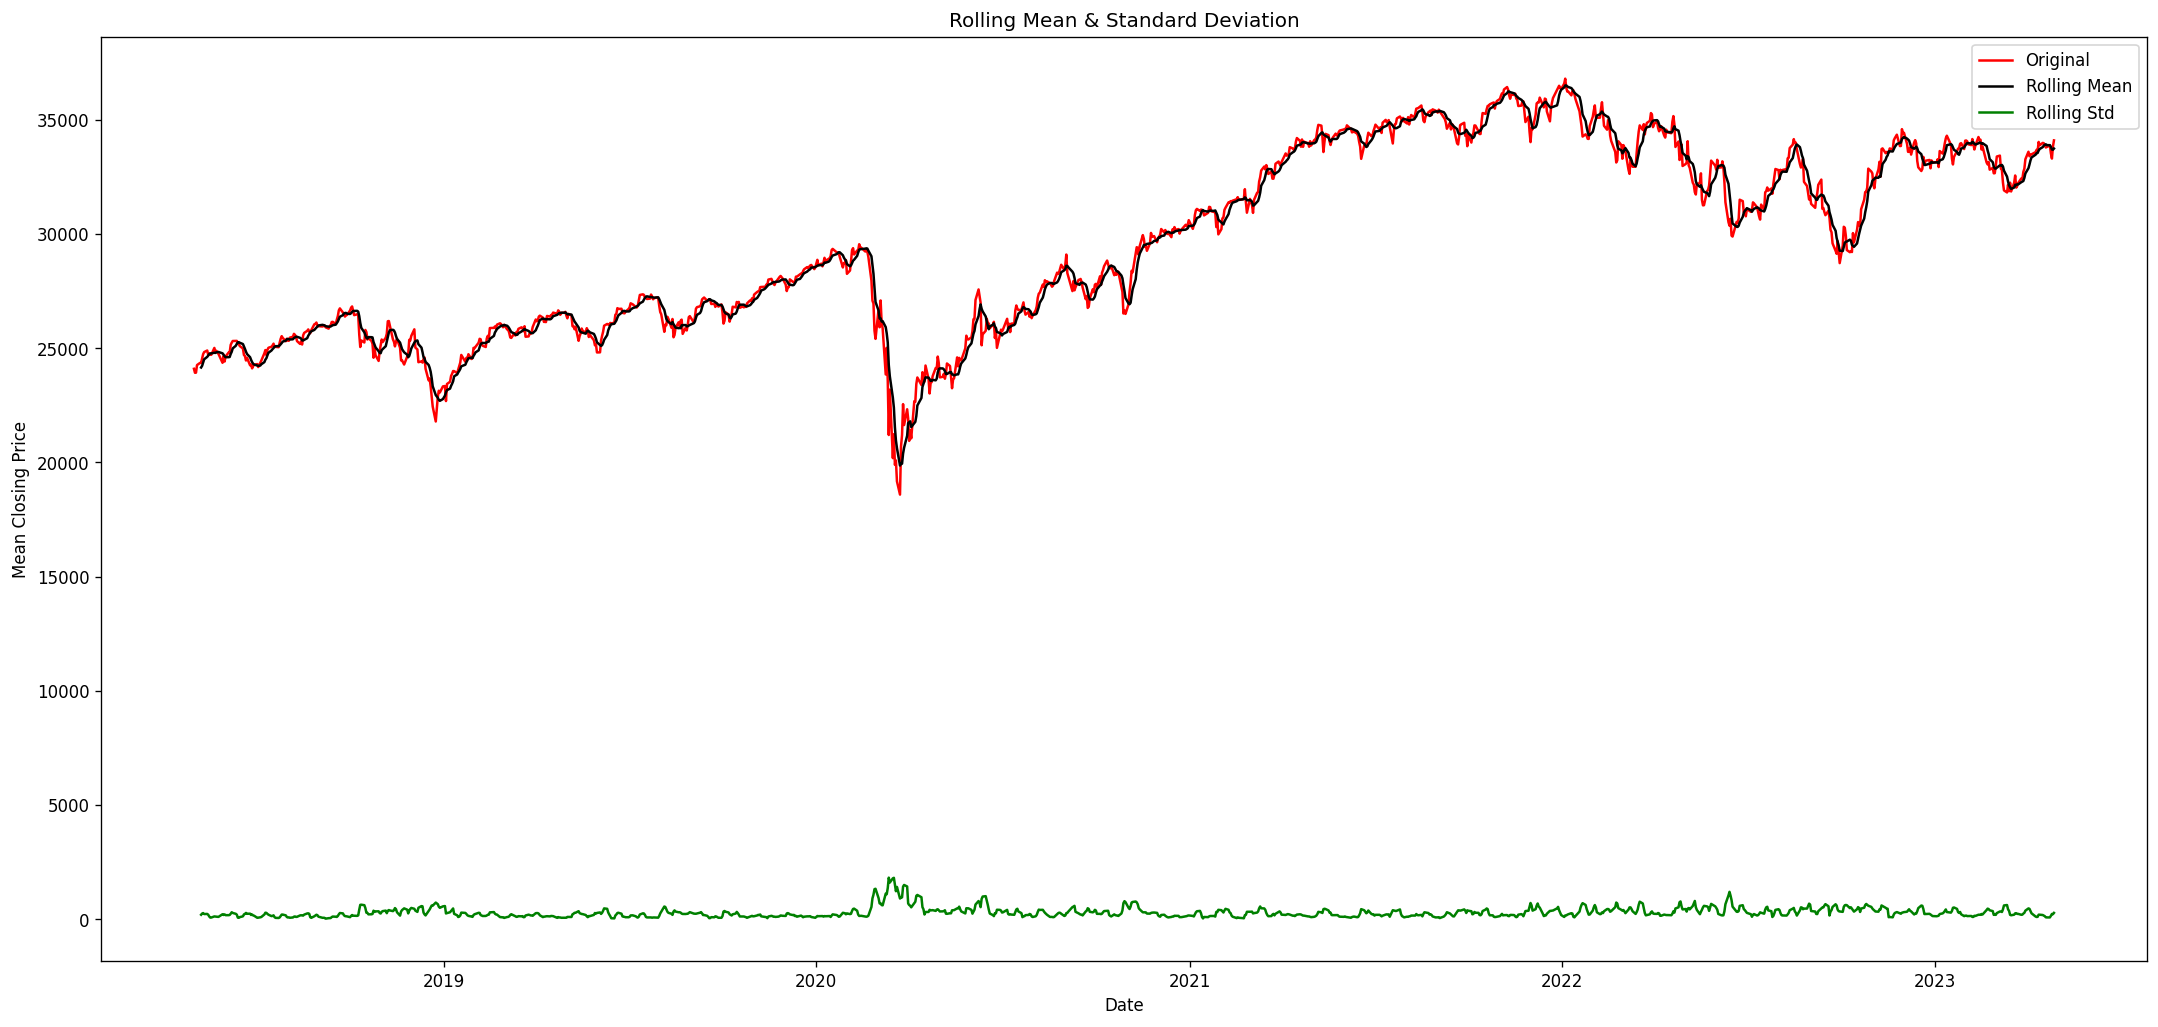

Test Statistic: -1.615959
p-value: 0.474849
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
check_mean_std(data)
check_adfuller(data)

Our data is not stationary => we need to difference it!

In [ ]:
data = data.diff().dropna()

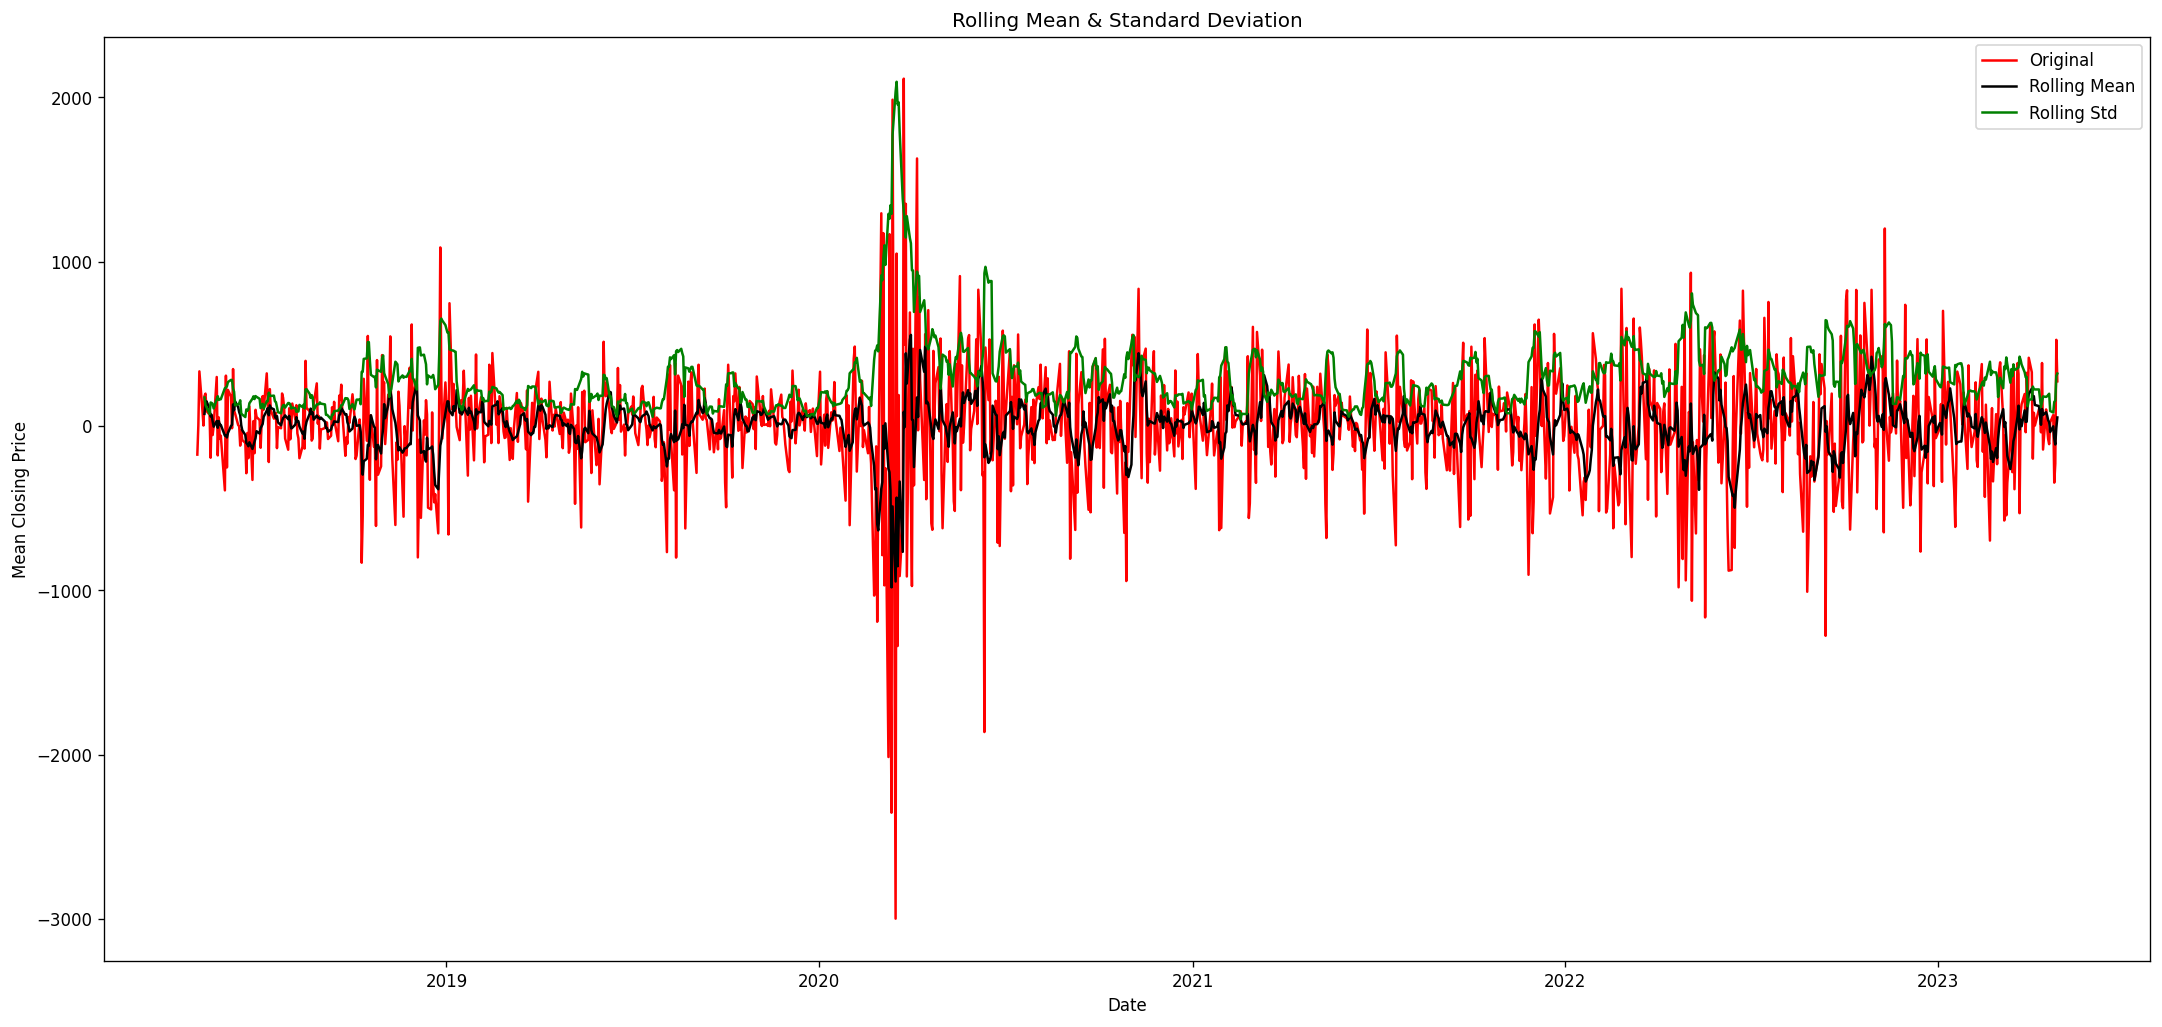

Test Statistic: -10.834416
p-value: 0.000000
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
check_mean_std(data)
check_adfuller(data)

now it is stationary so we can continue

### Finding d parameter

1 Differencing has less noise so we try it => d = 1

### Finding p parameter

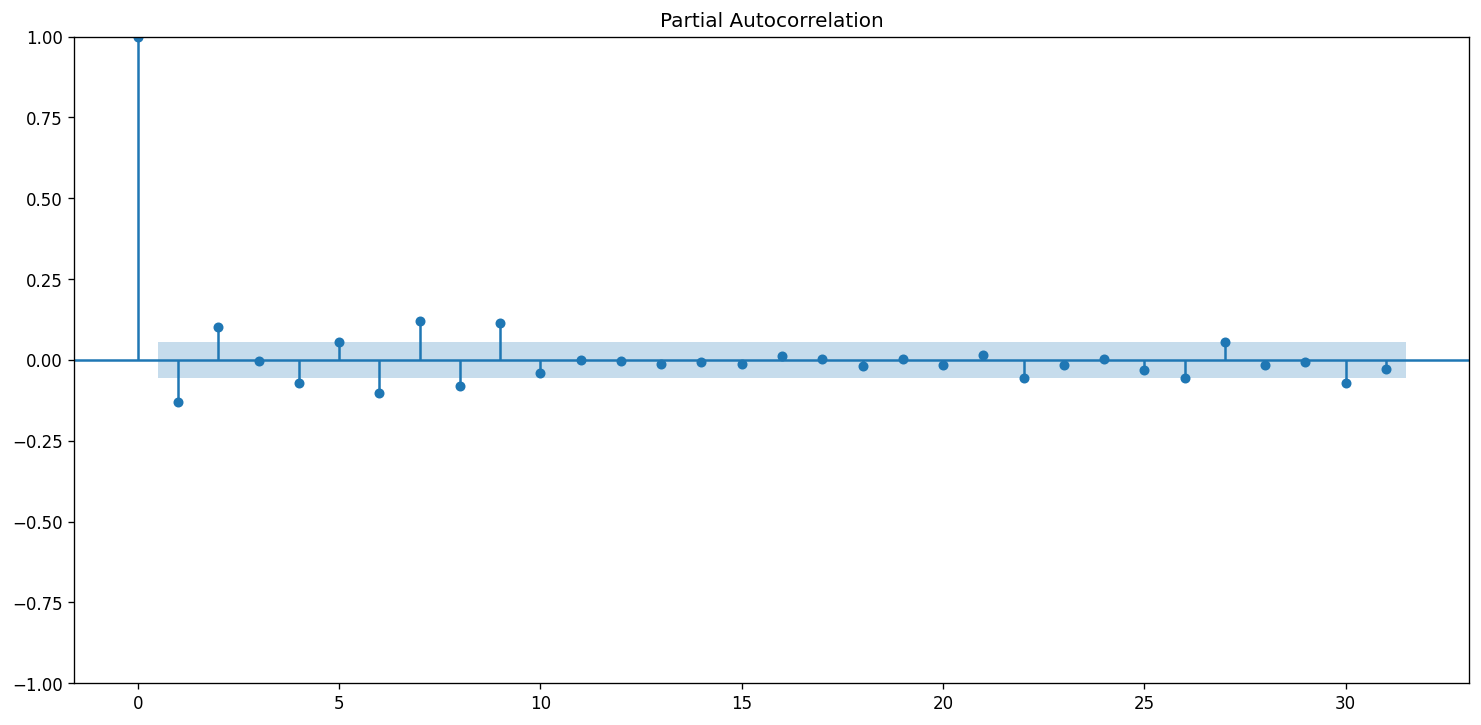

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(data.dropna())
plt.show()

We can set p = 7

### Finding q value

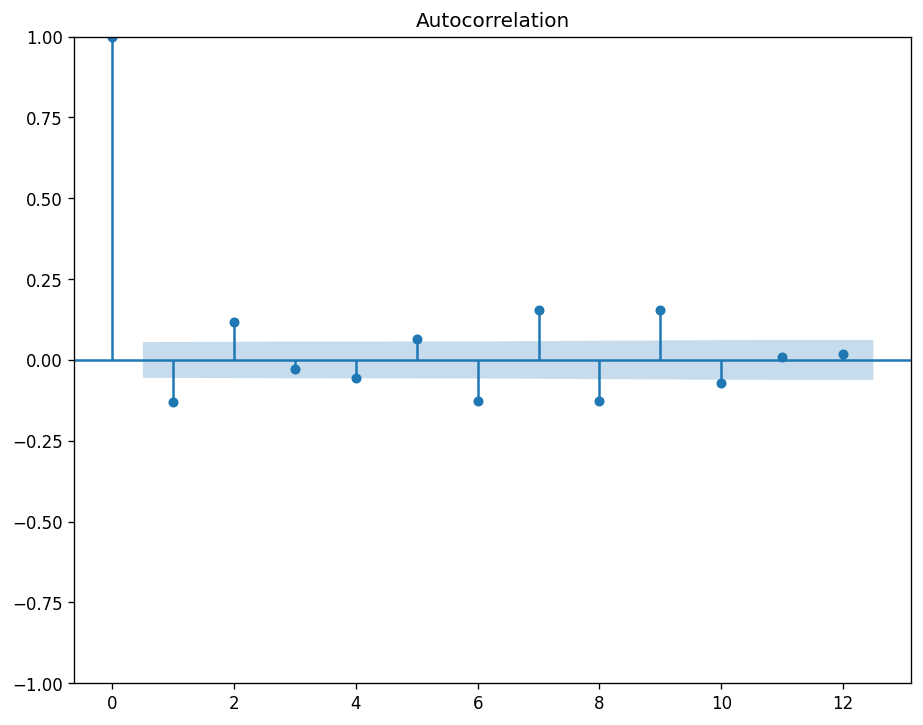

In [ ]:
plot_acf(data.dropna(), lags=12)
plt.show()

q value can be 7

# ARIMAX

In [ ]:
TEST_SIZE = int(len(df)*0.25)

In [ ]:
X = df[['Adj Close**']]
X = X.set_index(df['Date'])
X = X.dropna()
train, test = X[0:-TEST_SIZE], X[-TEST_SIZE:]
exogenous_train, exogenous_test = df['Open'][0:-TEST_SIZE].values, df['Open'][-TEST_SIZE:].values

model_arima = ARIMA(endog = train.values, exog=exogenous_train, order=(7, 1, 2)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast = model_arima.forecast(TEST_SIZE, exog=exogenous_test)
forecast = pd.DataFrame(forecast)
forecast = forecast.set_index(test.index)

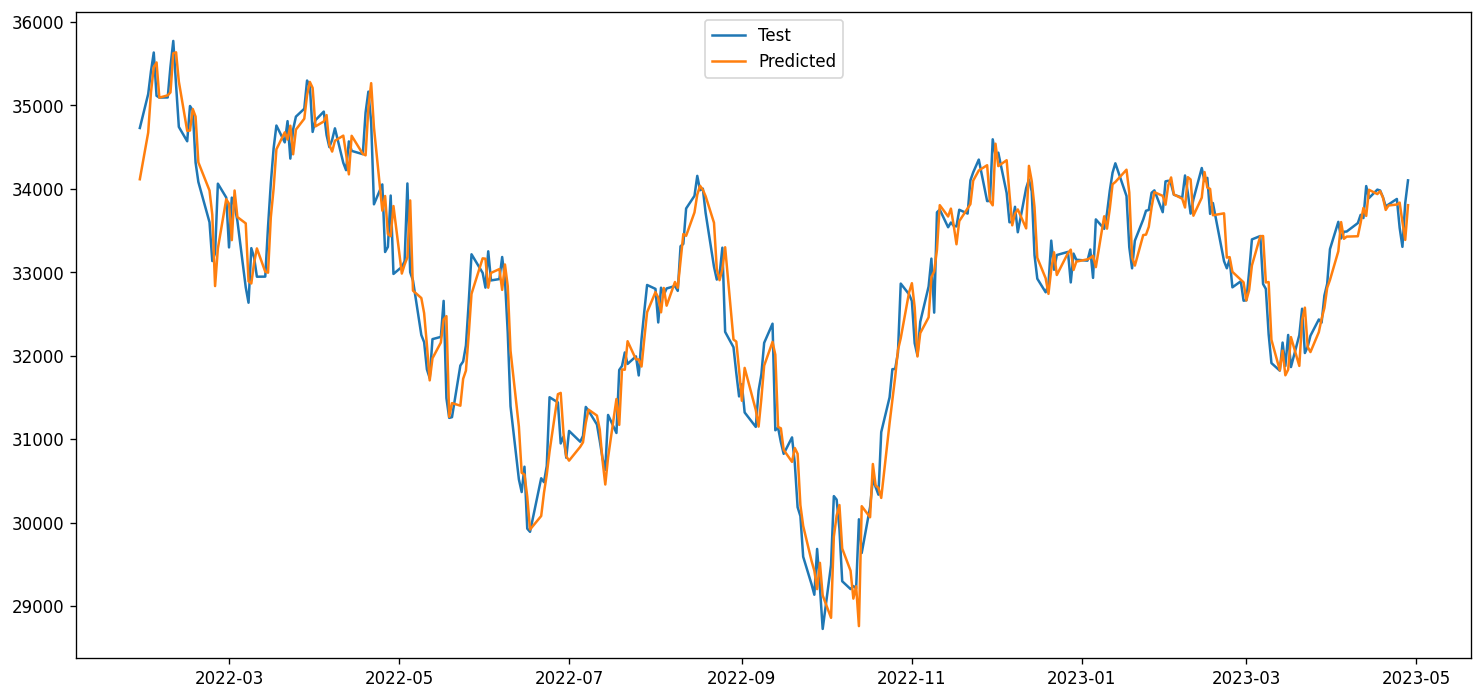

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicted')
leg = plt.legend(loc='upper center')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

RMSE = (mean_squared_error(test, forecast))**0.5

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print('RMSE', RMSE)
print('The Mean Absolute Percentage Error is: %.3f' % mape(np.array(test), forecast),'%.')

RMSE 337.7098470674951
The Mean Absolute Percentage Error is: 0.798 %.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# Catboost

In [ ]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

In [ ]:
df = df.drop('Adj Close Stationary', axis=1)
X = df.drop('Adj Close**', axis=1)
y = df['Adj Close**']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.1,
                          depth=4)
model.fit(X_train, y_train) # Fit model
preds = model.predict(X_test) # Get predictions

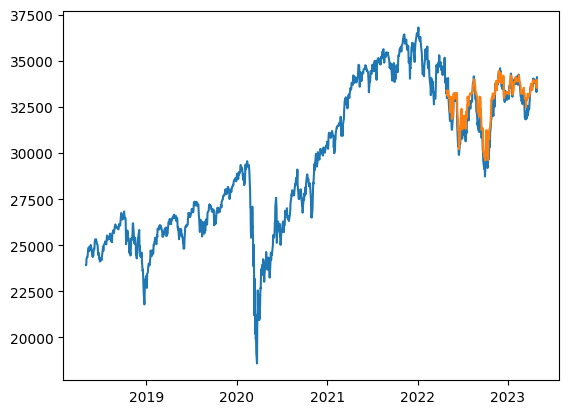

In [ ]:
plt.plot(df['Date'], df['Adj Close**'])
plt.plot(X_test['Date'], preds)
plt.show()

In [ ]:
model.best_score_

{'learn': {'RMSE': 163.7374985534965}}